De opdracht luidt als volgt: Voorspel de prijs voor een nieuwe
listing
 (nieuwe aanbieder van een huis) en presenteer kort wat je gedaan hebt en hebt bereikt.
We zijn benieuwd naar zowel je technische skills als je consultant skills. Denk daarbij aan de volgende zaken:  


•                 Welke
 features gebruik je (en waarom)?  

•                 Wat
 moet je aan pre-processing doen?  

•                 Wat
 is je aanpak mbt
 train/test split?  

•                 Welke
 algoritmes gebruik je en waarom?  

•                 Hoe
 evalueer je?  

•                 Welke
 problemen/uitdagingen voorzie je en hoe ga je daarmee om?  

•                 Hoe
 kan het model in de praktijk worden gebruikt, en hoe zou je de uitkomsten aan de
gebruiker
 tonen?  

•                 Wat
 zou je kunnen doen om het model evt. nog beter te maken?

 

Wees specifiek in je aanpak. Als je bijvoorbeeld zegt: ik ga een deep neural netwerk trainen, dan moet je daarbij wel uitleggen hoe dat netwerk er precies uitziet en de data die je erin wilt stoppen. We snappen dat het (te) veel werk is om een heel product uit te werken, maar probeer in ieder geval het verwerken van de data en het trainen van een model in code te zetten.

Je mag zelf kiezen hoe je dit presenteert, een powerpoint, jupyter notebook, etc.

Als laatste een tip! Probeer ‘hardop te denken’ zodat we je gedachtegang kunnen volgen en kunnen begrijpen waarom je bepaalde keuzes maakt.



Something to keep in mind is that modeling prices on all the scraped listings doesn’t make much sense. Many of these listings may be priced poorly or inactive and training a model on them wouldn’t necessarily suggest optimal prices. Therefore, defining what a “good” listing is and filtering out sub-optimal listings was the first step in the data cleaning process. One key feature to keep track of was occupancy, which wasn’t a feature included in the dataset.

'reviews_per_month': dtype('float64')} --> could be used to estimate the occupancy

check 'access' to find smart lock 

sources:
https://towardsdatascience.com/airbnb-pricing-recommender-19225d0f5d1

Ideas, can I use another airbnb dataset to tune a model on an finetune on this one to get extra data?


make two models --> low price and high price

 Something to note though is that there are definitely other factors such as seasonality, demand, and day of the week to take into account when considering price. While the dataset I used didn’t have a great way to incorporate these factors, next steps on improving this project would be to use a time series model to address seasonality and figuring out a way to model demand.

# Data cleaning

In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
%matplotlib inline


In [194]:
df = pd.read_csv('/content/listings_summary.csv')

In [196]:
# df.head()
# df.describe()
# df.columns

### Numerical features

In [ ]:
# Should look into cleaning city, strange there are other values too
df['city'].value_counts()

In [198]:
# convert superhost boolean to 0 - 1
df['host_is_superhost'] = df['host_is_superhost'].str.replace('t','1')
df['host_is_superhost'] = df['host_is_superhost'].str.replace('f','0')
df['host_is_superhost'] = df['host_is_superhost'].fillna(0)
df['host_is_superhost'] = df['host_is_superhost'].astype(int)

In [199]:
# not significant
df['host_has_profile_pic'] = df['host_has_profile_pic'].str.replace('t','1')
df['host_has_profile_pic'] = df['host_has_profile_pic'].str.replace('f','0')
df['host_has_profile_pic'] = df['host_has_profile_pic'].fillna(0)
df['host_has_profile_pic'] = df['host_has_profile_pic'].astype(int)

In [200]:
df['is_location_exact'] = df['is_location_exact'].str.replace('t','1')
df['is_location_exact'] = df['is_location_exact'].str.replace('f','0')
df['is_location_exact'] = df['is_location_exact'].fillna(0)
df['is_location_exact'] = df['is_location_exact'].astype(int)

In [183]:
# Only 208, if it were more it would have been a possible feature
df['host_about'].isna().sum()

208

In [201]:
# convert price to floats
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace(',', '')
df['price'] = df['price'].astype('float')

# Since there are only 74 apartments with a price above 500 we exclude them for now
df = df[df['price'] < 500]

<ipython-input-201-eca4e156432e>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df['price'].str.replace('$', '')


In [202]:
# filter out the apartments that host more than 12
# df['accommodates'].value_counts()
df = df[df['accommodates'] < 12]

In [ ]:
df['security_deposit'] = df['security_deposit'].str.replace('$', '')
df['security_deposit'] = df['security_deposit'].str.replace(',', '').astype(float)

# Really high security deposits do not make sense, therefore I remove them from the data
df['security_deposit'].hist(bins=50)

In [204]:
# Is this okay?
df = df[df['security_deposit'] < 500]

In [205]:
# Find active listings only, if a property had not been booked for over a year, either the price is bad or there is something else wrong with it. Therefore we do not want these entries in our training data

# df[['number_of_reviews', 'reviews_per_month', 'first_review', 'last_review']]
# df['number_of_reviews'].value_counts()

df['days_since_review'] = pd.to_datetime('2018-11-07')- pd.to_datetime(df['last_review'])
df['days_since_review'] = df['days_since_review'].dt.days

Text(0, 0.5, 'Count')

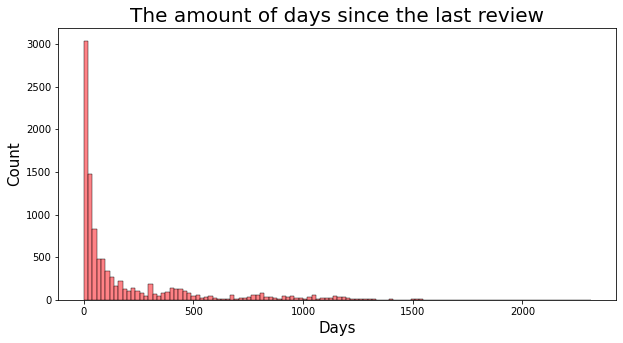

In [206]:
fig, ax = plt.subplots(figsize=(10,5)) 
sns.histplot(df['days_since_review'], color='#FF585D')
ax.set_title('The amount of days since the last review', fontsize=20)
ax.set_xlabel('Days', fontsize=15)
ax.set_ylabel('Count', fontsize=15)

In [207]:
df.shape

(11419, 97)

In [208]:
df = df[df['days_since_review'] < 365]

In [209]:
df.shape

(8210, 97)

In [ ]:
df['square_feet'].value_counts()

In [ ]:
dict(df.isna().sum())


In [116]:
df['host_response_rate'].isna().sum()

5511

In [211]:
# is averaging the right method here?
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '')
df['host_response_rate'] = df['host_response_rate'].astype(float)


In [212]:
mean_response = df['host_response_rate'].mean()
mean_response

94.19788127123726

In [213]:
df['host_response_rate'] = df['host_response_rate'].fillna(mean_response) 

In [247]:
#find the number of amenities in a listing, now it is a numerical feature, and a significant one according to OLS
df['num_amenities'] = df['amenities'].apply(len)

### Categorical features

In [ ]:
df.columns

In [214]:
# change the uncommon property types to their closest resemblance 
df['property_type'] = df['property_type'].replace({
    'Villa' : 'House',
    'Hut' : 'House',
    'Guesthouse' : 'House',
    'Townhouse' : 'House',
    'Bungalow' : 'House',
    'Tiny house' : 'House',
    'Aparthotel' : 'Apartment',
    'Serviced apartment' : 'Apartment',
    'Bed and breakfast' : 'Other',
    'Boutique hotel' : 'Other',
    'Hotel' : 'Other',
    'Loft' : 'Other',
    'Guest suite' : 'Other',
    'Camper/RV' : 'Other',
    'Dorm' : 'Other',
    'Cabin' : 'Other',
    'Houseboat' : 'Other',             
    'Boat' : 'Other',                  
    'Resort' : 'Other',                
    'Cottage' : 'Other',               
    'Castle' : 'Other',                
    'Chalet' : 'Other',                
    'Train' : 'Other',                 
    'Cave' : 'Other',                  
    'Barn' : 'Other',                  
    'Casa particular (Cuba)': 'Other', 
    'In-law' : 'Other'
})

In [215]:
df['property_type'].value_counts()

Apartment      7310
Other           331
Condominium     250
House           241
Hostel           78
Name: property_type, dtype: int64

In [216]:
# No need to change things since only three categories
df['room_type'].value_counts()

Private room       4087
Entire home/apt    4001
Shared room         122
Name: room_type, dtype: int64

In [219]:
# df['neighbourhood'].value_counts().head(20)

# 136 values, since neighbourhood only has 96 we take that one
# df['neighbourhood_cleansed'].value_counts()

In [ ]:
# Just perfect!
df['neighbourhood_group_cleansed'].value_counts()

# Data preparation


In [222]:
# Almost 90% of the listings are below 100 dollar. therefore it may be beneficial to create two models, one for lower priced apartments and one for expensive apartments, the tricky thing is to choose beforehand which model should be used for a new listing...
 
df[df['price'] < 100].shape[0] / df['price'].shape[0] * 100


88.00243605359319

In [223]:
# model1 = df[(df['price'] < 150) & (df['accommodates'] <= 10)]
# model1 = df[df['price'] < 150]


https://docs.fast.ai/tutorial.tabular.html

In [226]:
# dict(df.dtypes)

In [227]:
df_one_hot = pd.get_dummies(df[['property_type', 'room_type', 'neighbourhood_group_cleansed']], prefix=['property_type', 'room_type', 'neighbourhood'])
df_one_hot

,property_type_Apartment,property_type_Condominium,property_type_Hostel,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_Charlottenburg-Wilm.,neighbourhood_Friedrichshain-Kreuzberg,neighbourhood_Lichtenberg,neighbourhood_Marzahn - Hellersdorf,neighbourhood_Mitte,neighbourhood_Neukölln,neighbourhood_Pankow,neighbourhood_Reinickendorf,neighbourhood_Spandau,neighbourhood_Steglitz - Zehlendorf,neighbourhood_Tempelhof - Schöneberg,neighbourhood_Treptow - Köpenick
0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22330,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
22338,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
22401,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
22442,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [248]:
# 'security_deposit' is not significant 

numeric_variables = ['host_is_superhost', 'num_amenities', 'host_has_profile_pic', 'is_location_exact', 'host_response_rate', 'host_acceptance_rate','guests_included','maximum_nights','host_listings_count','minimum_nights','availability_30','availability_60',
 'square_feet','beds','availability_90','availability_365','number_of_reviews','review_scores_rating',
 'review_scores_accuracy','accommodates','bathrooms','bedrooms','review_scores_cleanliness','review_scores_checkin',
'review_scores_communication','review_scores_location','review_scores_value','jurisdiction_names','calculated_host_listings_count','reviews_per_month']

df_numeric = df[numeric_variables].fillna(0)



In [249]:
X = pd.concat([df_numeric, df_one_hot], axis=1)
y = df['price'] # target variable

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X.head()

# OLS

In [ ]:
std = StandardScaler() 
std.fit(X_train.values) 
X_train_scaled = std.transform(X_train.values)
train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
model = sm.OLS(np.array(y_train), sm.add_constant(train_df))

fit = model.fit()
fit.summary()

In [259]:
# X_test_scaled = std.transform(X_test.values)
ypred = model.predict(X_test_scaled[0])


ValueError: ignored

In [257]:
X_test_scaled[0]

array([-0.54228951, -1.08537107,  0.0437917 ,  0.52290755,  0.50607602,
        0.        , -0.49266061, -0.59933033,  2.68746893,  1.98185439,
       -0.74520854, -0.84104003, -0.09006642,  0.22138219, -0.72911522,
        1.43874739, -0.59593558,  0.52426755,  0.33577633,  0.77691269,
       -0.29325116,  1.29744657, -1.03963104,  0.29813545,  0.28040382,
       -0.3986942 , -1.11045936,  0.        ,  3.19452062, -0.89146588,
        0.34648892, -0.17406205, -0.09368324, -0.17406205, -0.20325312,
        1.03416607, -1.00680933, -0.11653432, -0.27018927, -0.56455663,
       -0.17774187, -0.07827804,  1.96208793, -0.41777392, -0.4458589 ,
       -0.11805887, -0.07939537, -0.12613284, -0.27716815, -0.1631461 ])

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.plot([0,150], [0,150], c='#FF5A5F')
plt.scatter(val_pred, y_val, color='#00A699', alpha=0.4)
sns.despine()
plt.ylabel('Actual Price', size=15)
plt.xlabel('Predicted Price', size=15)
plt.title('Actual vs Predicted Prices (Linear Regression)', size=18);
# plt.savefig('actual_plot', bbox_inches ='tight', dpi = 400)

# Random forest regressor

In [103]:
# Split the data into training and testing sets
# X = df.drop(['price', 'weekly_price', 'monthly_price'], axis=1) # input features
# X = df[numeric_variables].fillna(0)

# Create and fit the random forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) # set hyperparameters
rf_model.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Random Forest Regression RMSE:', rmse)


Random Forest Regression RMSE: 31.154286510543596


# EDA

In [10]:
df[df['price'] > 500]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
78,102882,https://www.airbnb.com/rooms/102882,20181107122246,2018-11-07,STORAGE APARTMENT URBAN,Storage Berlin - Contemporary and innovative l...,Rent one of the rooms as single traveller or a...,Storage Berlin - Contemporary and innovative l...,none,NaN,...,t,NaN,NaN,t,f,strict_14_with_grace_period,f,t,2,1.24
766,810056,https://www.airbnb.com/rooms/810056,20181107122246,2018-11-07,20m2 of relaxation ***,Dear travellers - I'm renting out a 20 sq mete...,"Atelier/Logement de 52 M2, au 3ème étage d'un ...",Dear travellers - I'm renting out a 20 sq mete...,none,Ici c'est tous les jours dimanche.,...,t,NaN,NaN,f,f,flexible,f,f,4,0.74
848,885925,https://www.airbnb.com/rooms/885925,20181107122246,2018-11-07,LOFT- 8 minutes from train station!,"This amazing loft, which has already been feat...",This incredible loft of over (Phone number hid...,This incredible loft of over (Phone number hid...,none,NaN,...,t,NaN,NaN,f,f,moderate,f,f,1,0.55
1270,1525270,https://www.airbnb.com/rooms/1525270,20181107122246,2018-11-07,Voll ausgestattetes Dachloft mit Blick über Be...,Penthouse im 5. Stock (mit Aufzug) mit großer ...,NaN,Penthouse im 5. Stock (mit Aufzug) mit großer ...,none,Die Wohnung befindet sich in unmittelbarer Näh...,...,t,02/Z/RA/008889-18,NaN,f,f,moderate,f,f,1,NaN
1990,2860420,https://www.airbnb.com/rooms/2860420,20181107122246,2018-11-07,250 qm penthouse with roof terrace for photoshoot,For Photoshoots and events. Exceptional 250sqm...,NaN,For Photoshoots and events. Exceptional 250sqm...,none,NaN,...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21826,29022524,https://www.airbnb.com/rooms/29022524,20181107122246,2018-11-07,Gorki Penthouse 1,NaN,"Spread across 200 square meters, this luxury p...","Spread across 200 square meters, this luxury p...",none,NaN,...,t,NaN,NaN,t,f,super_strict_60,f,f,6,NaN
22332,29642132,https://www.airbnb.com/rooms/29642132,20181107122246,2018-11-07,Einzigartiges Penthouse über den Dächern Berlins!,Einzigartiges Penthouse in der Mitte Berlin Mi...,Diese ideal geschnittene Dachgeschosswohnung l...,Einzigartiges Penthouse in der Mitte Berlin Mi...,none,NaN,...,t,NaN,NaN,f,f,flexible,f,f,1,NaN
22372,29684637,https://www.airbnb.com/rooms/29684637,20181107122246,2018-11-07,Cool Luxury meets Amazing Design!,This super Luxury loft is located directly on ...,Refurbished in 2016 and luxuriously furnished ...,This super Luxury loft is located directly on ...,none,NaN,...,t,NaN,NaN,t,f,flexible,f,f,2,NaN
22395,29706171,https://www.airbnb.com/rooms/29706171,20181107122246,2018-11-07,Most amazing flat in Berlin,Your home is your castle. You can pull up the ...,"Kitchen, Toilet, stupid stuff on the wall. Use...",Your home is your castle. You can pull up the ...,none,"Its wedding, a unique mix of people that never...",...,t,NaN,NaN,t,f,flexible,f,f,1,NaN


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


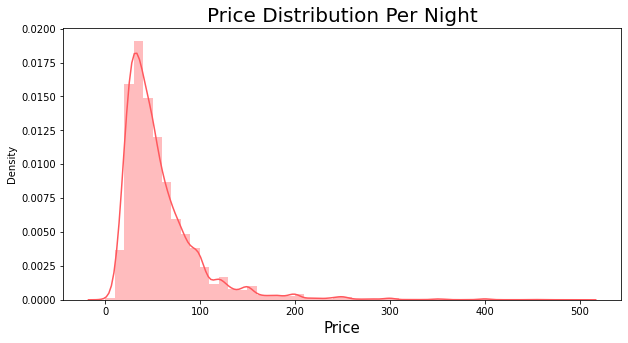

In [13]:
fig, ax = plt.subplots(figsize=(10,5)) 
ax = sns.distplot(df['price'], color='#FF585D')
ax.set_title('Price Distribution Per Night', fontsize=20);
ax.set_xlabel('Price', fontsize=15);
plt.savefig('price', bbox_inches ='tight', dpi = 400)

In [17]:
df[['guests_included', 'extra_people', 'space', 'accommodates']]

,guests_included,extra_people,space,accommodates
0,1,$28.00,A+++ location! This „Einliegerwohnung“ is an e...,3
1,1,$0.00,In the summertime we are spending most of our ...,2
2,2,$20.00,1st floor (68m2) apartment on Kollwitzplatz/ P...,4
3,1,$18.00,"Your room is really big and has 26 sqm, is ver...",2
4,1,$24.00,"The BrightRoom is an approx. 20 sqm (215ft²), ...",2
...,...,...,...,...
22547,1,$0.00,NaN,2
22548,1,$10.00,Die Übernachtungsmöglichkeit ist offen im Wohn...,6
22549,1,$0.00,NaN,2
22550,1,$0.00,"Nearby you will find the Brandenburg Gate, Rei...",2
